In [1]:
import os
import time
import shutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from tqdm import tqdm
from termcolor import colored
from datetime import datetime
from PIL import Image

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Conv2D, UpSampling2D, BatchNormalization,Reshape,Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, Activation,Add,LeakyReLU,Flatten,Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from dataloader import get_ref_num_list, DataLoader

gpus = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_visible_devices(gpus[3], 'GPU')

# 모델 구축 (ResUnet)

In [5]:
def conv_block(inp,filters,strides,kernel_size=(3,3),padding="same"):
    conv = layers.Conv2D(filters, kernel_size=kernel_size, padding=padding, strides=strides[0])(inp)
    bn_act = bn_act_block(conv)
    conv = layers.Conv2D(filters, kernel_size=kernel_size, padding=padding, strides=strides[1])(bn_act)
    return conv 

def bn_act_block(inp):
    bn = layers.BatchNormalization()(inp)
    act = layers.Activation('relu')(bn)
    return act

def inp_concat(ref_img,c1,c2):
    img_size = 128
    c1_layer = layers.RepeatVector(img_size * img_size)(c1)
    c1_layer = layers.Reshape([img_size, img_size, 1])(c1_layer)
    c2_layer = layers.RepeatVector(img_size * img_size)(c2)
    c2_layer = layers.Reshape([img_size, img_size, 1])(c2_layer)
    concat = layers.Concatenate(axis=-1)([ref_img, c1_layer, c2_layer])
    return concat

def shortcut(inp,filters,strides,kernel_size=(3,3),padding="same"):
    shortcut_conv = layers.Conv2D(filters, kernel_size=(1,1), padding=padding, strides=strides)(inp)
    shortcut_bn = layers.BatchNormalization()(shortcut_conv)
    return shortcut_bn
    
def residual_block(inp,filters,kernel_size=(3,3),padding="same",strides=[1,1],act=True):
    sc = shortcut(inp,filters,strides[0])
    if act == True:
        inp = bn_act_block(inp)
    conv = conv_block(inp,filters,strides)
    add = layers.Add()([conv, sc])
    return add

def upsample_and_concat(inp1,inp2):
    upsample = layers.UpSampling2D((2, 2))(inp1)
    concat = layers.Concatenate()([upsample,inp2])
    return concat

In [8]:
def resUnet():
    f = [16, 32, 64, 128, 256, 512]
    img_size = 128
    ref_img = layers.Input(shape=(img_size,img_size,1))
    c1      = layers.Input(shape=(1,))
    c2      = layers.Input(shape=(1,))
    inp     = inp_concat(ref_img,c1,c2)
    e       = residual_block(inp, f[0])
    e1      = residual_block(e,f[1],act=False)
    e2      = residual_block(e1,f[2],strides=[2,1])
    e3      = residual_block(e2,f[3],strides=[2,1])
    e4      = residual_block(e3,f[4],strides=[2,1])
    bridge  = residual_block(e4,f[5],strides=[2,1])
    us_c    = upsample_and_concat(bridge,e4)
    d1      = residual_block(us_c,f[4])
    us_c1   = upsample_and_concat(d1,e3)
    d2      = residual_block(us_c1,f[3])
    us_c2   = upsample_and_concat(d2,e2)
    d3      = residual_block(us_c2,f[2])
    us_c3   = upsample_and_concat(d3,e1)
    d4      = residual_block(us_c3,f[1])
    out     = layers.Conv2D(2,kernel_size=(1,1),activation='sigmoid')(d4)
    return Model([ref_img,c1,c2],out)

# 하이퍼 파라미터 설정

In [10]:
# 데이터 경로 불러오기 
ref_path = '../data/reference_image/'
lbl_path = '../data/binary_label_11/'
# 학습 데이터 인덱스 불러오기
train_ref_num = np.load('../TopOpNet/train_ref_num.npy')
valid_ref_num = np.load('../TopOpNet/valid_ref_num.npy')
test_ref_num = np.load('../TopOpNet/test_ref_num.npy')
tdl = DataLoader(ref_path, lbl_path, n_batch=batch_size, ref_num_list=train_ref_num, pdf_npy=None, from_mem=True)
vdl = DataLoader(ref_path, lbl_path, n_batch=batch_size, ref_num_list=valid_ref_num, pdf_npy=None, from_mem=True)

In [45]:
lr = 0.0001
batch_size = 64 
model = resUnet()
loss = tf.keras.losses.categorical_crossentropy
optimizer = tf.keras.optimizers.Adam(learning_rate=lr) 
trainable_variables = model.trainable_variables
model = resUnet()
model.compile(loss=loss,optimizer=optimizer,metrics='acc')

In [47]:
best_loss = 1
for iterate in range(50000):
    ref_imgs, c1, c2, opt_imgs = tdl.get_next()
    train_loss,acc = model.train_on_batch([ref_imgs,c1,c2],keras.backend.one_hot(opt_imgs, 2))
    if iterate%100 ==0:
        ref_imgs, c1, c2, opt_imgs = vdl.get_next()
        val_loss,val_acc = model.test_on_batch([ref_imgs, c1, c2],keras.backend.one_hot(opt_imgs, 2))
    
        if best_loss > val_loss : 
            best_loss = val_loss
            tf.keras.models.save_model(model, './20210123_baseline2_model.h5')
            print(colored('model saved','cyan'))

        print('iteration:',colored(iterate,'blue')
             ,'train_loss:',colored(np.round(train_loss,4),'red'),'train_acc:',colored(np.round(acc,4),'red'),'%'
             ,'val_loss:',colored(np.round(val_loss,4),'yellow'),'val_acc:',colored(np.round(val_acc,4),'yellow'),'%')

model saved
iteration: 0 train_loss: 0.7706 train_acc: 0.5459 % val_loss: 0.7536 val_acc: 0.565 %
model saved
iteration: 100 train_loss: 0.1378 train_acc: 0.9465 % val_loss: 0.3597 val_acc: 0.8372 %
model saved
iteration: 200 train_loss: 0.119 train_acc: 0.9503 % val_loss: 0.2561 val_acc: 0.8912 %
model saved
iteration: 300 train_loss: 0.0928 train_acc: 0.9618 % val_loss: 0.1308 val_acc: 0.9472 %
model saved
iteration: 400 train_loss: 0.0971 train_acc: 0.9579 % val_loss: 0.1014 val_acc: 0.9575 %
model saved
iteration: 500 train_loss: 0.0855 train_acc: 0.9639 % val_loss: 0.0899 val_acc: 0.9625 %
model saved
iteration: 600 train_loss: 0.0862 train_acc: 0.9631 % val_loss: 0.0819 val_acc: 0.9654 %
model saved
iteration: 700 train_loss: 0.0868 train_acc: 0.9624 % val_loss: 0.0809 val_acc: 0.9659 %
iteration: 800 train_loss: 0.0806 train_acc: 0.965 % val_loss: 0.0856 val_acc: 0.9628 %
iteration: 900 train_loss: 0.0731 train_acc: 0.9683 % val_loss: 0.0824 val_acc: 0.9642 %
model saved
iterati

In [83]:
def sample_images(gen_imgs,image_grid_rows=4, image_grid_columns=4):
    # 이미지 픽셀 값을 [0, 1] 사이로 스케일 조정
    gen_imgs = 0.5 * gen_imgs + 0.5
    
    # 이미지 그리드 설정
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)
    
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # 이미지 그리드 출력
            axs[i, j].imshow(gen_imgs[cnt, :, :], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

In [49]:
trained_model = tf.keras.models.load_model('./20210123_baseline2_model.h5')

In [50]:
import matplotlib.pyplot as plt
def ds_load(ref_num):
    lbl_names,ref_list, c1_list, c2_list = [], [], [] ,[]
    ref_imgs, opt_imgs = [],[]
    for i in range(len(ref_num)):
        for lbl_name in os.listdir(lbl_path):
            ref_from_lbl = lbl_name.split('_')[0]
            if str(i) == ref_from_lbl:
                lbl_names.append(lbl_name)
                #이미지 불러오기
                ref_img = cv2.imread(ref_path+'Binary_{}.jpg'.format(i),cv2.IMREAD_GRAYSCALE)
                _,ref_img = cv2.threshold(ref_img,127,255,cv2.THRESH_BINARY_INV)
                ref_imgs.append(ref_img/255.)
                opt_img = cv2.imread(lbl_path+lbl_name,cv2.IMREAD_GRAYSCALE)
                _,opt_img = cv2.threshold(opt_img,127,255,cv2.THRESH_BINARY_INV)
                opt_imgs.append(opt_img/255.)
                # c값 불러오기
                lbl_name=lbl_name.split('.png')
                lbl_name=lbl_name[0].split('_')
                ref,c1,c2=lbl_name
                ref_list.append(np.int(ref))
                c1_list.append(np.float(c1))
                c2_list.append(np.float(c2))
    return np.asarray(ref_imgs),np.asarray(opt_imgs),\
            np.asarray(ref_list),np.asarray(c1_list),np.asarray(c2_list),\
             np.asarray(lbl_names)

In [55]:
os.makedirs('./baseline2/testset/gen_imgs/')

In [77]:
def save_result(gen_imgs,opt_imgs,valid_ds,lbl_names):
    ref_list, c1_list, c2_list = valid_ds
    print(len(ref_list))
    for i in range(len(ref_list)):
        gen_img,opt_img = gen_imgs[i]*255,opt_imgs[i]*255
        gen_img,opt_img = gen_img.astype(np.uint8),opt_img.astype(np.uint8)
        gen_img,opt_img = Image.fromarray(gen_img),Image.fromarray(opt_img)

        savename = lbl_names[i]
        gen_img.save('./baseline2/testset/gen_imgs/'+savename)
        opt_img.save('./baseline2/testset/gt_imgs/'+savename) 
        

In [78]:
ref_imgs, opt_imgs, ref_list, c1_list, c2_list, lbl_names = ds_load(test_ref_num) #valid set 전체 불러오기 
prep_c1_list = np.log10(c1_list) # c1 log10으로 전처리

In [79]:
start,stop = 0,len(ref_imgs)
gen_imgs = trained_model.predict([ref_imgs[start:stop], prep_c1_list[start:stop], c2_list[start:stop]])
gen_imgs = gen_imgs[:,:,:,1]
valid_ds = ref_list[start:stop], c1_list[start:stop], c2_list[start:stop]
save_result(gen_imgs,opt_imgs[start:stop],valid_ds,lbl_names[start:stop])

4598


<Figure size 1440x1440 with 0 Axes>

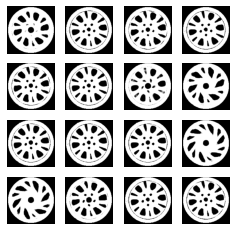

In [84]:
sample_images(gen_imgs)

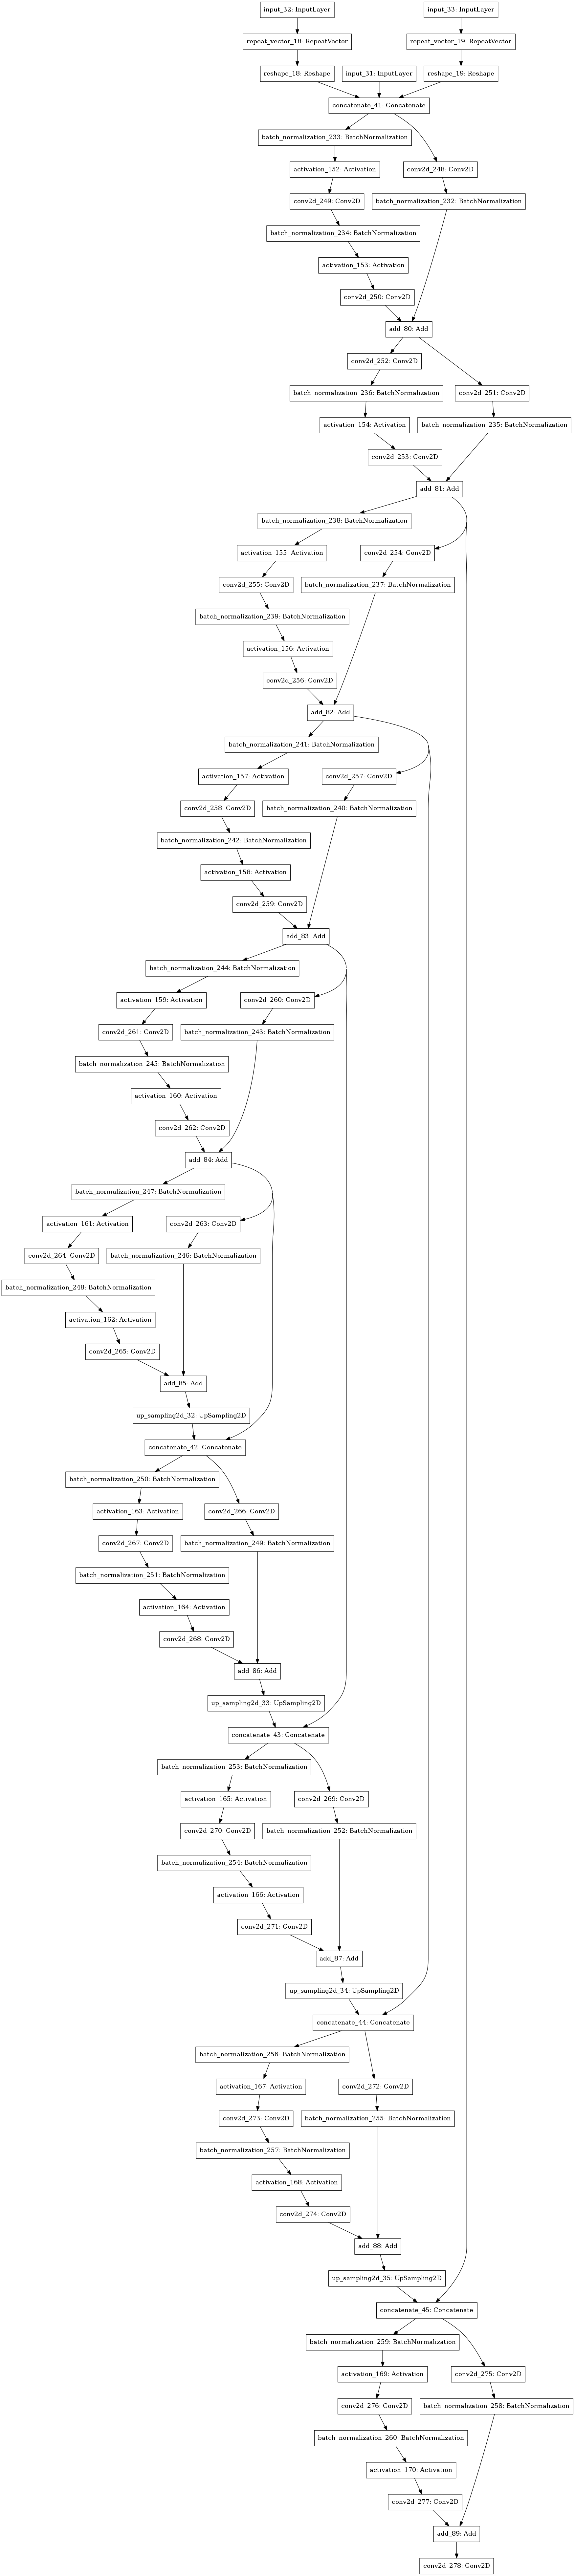

In [85]:
plot_model(model)